In [1]:
!pip install -q -U accelerate peft git+https://github.com/huggingface/diffusers torch-model-archiver


[notice] A new release of pip available: 22.2.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [2]:
import torch
from diffusers import StableDiffusionXLPipeline, DiffusionPipeline

from accelerate.utils import write_basic_config
write_basic_config()

!chmod -R 775 tuning-data tuned-weights

Configuration already exists at /opt/app-root/src/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


In [3]:
!rm -rf tuning-data/.ipynb_checkpoints

!accelerate launch scripts/train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path=stabilityai/stable-diffusion-xl-base-1.0  \
  --instance_data_dir=tuning-data \
  --output_dir=tuned-weights \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of a Tyrannosaurus Rex" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=100 \
  --seed="0" 

10/15/2024 22:06:21 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'dynamic_thresholding_ratio', 'clip_sample_range', 'variance_type', 'thresholding', 'rescale_betas_zero_snr'} was not found in config. Values will be initialized to default values.
{'shift_factor', 'use_post_quant_conv', 'use_quant_conv', 'latents_std', 'latents_mean', 'mid_block_add_attention'} was not found in config. Values will be initialized to default values.
{'attention_type', 'reverse_transformer_layers_per_block', 'dropout'} was not found in config. Values will be initialized to default values.
10/15/2024 

In [4]:
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.load_lora_weights("./tuned-weights")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

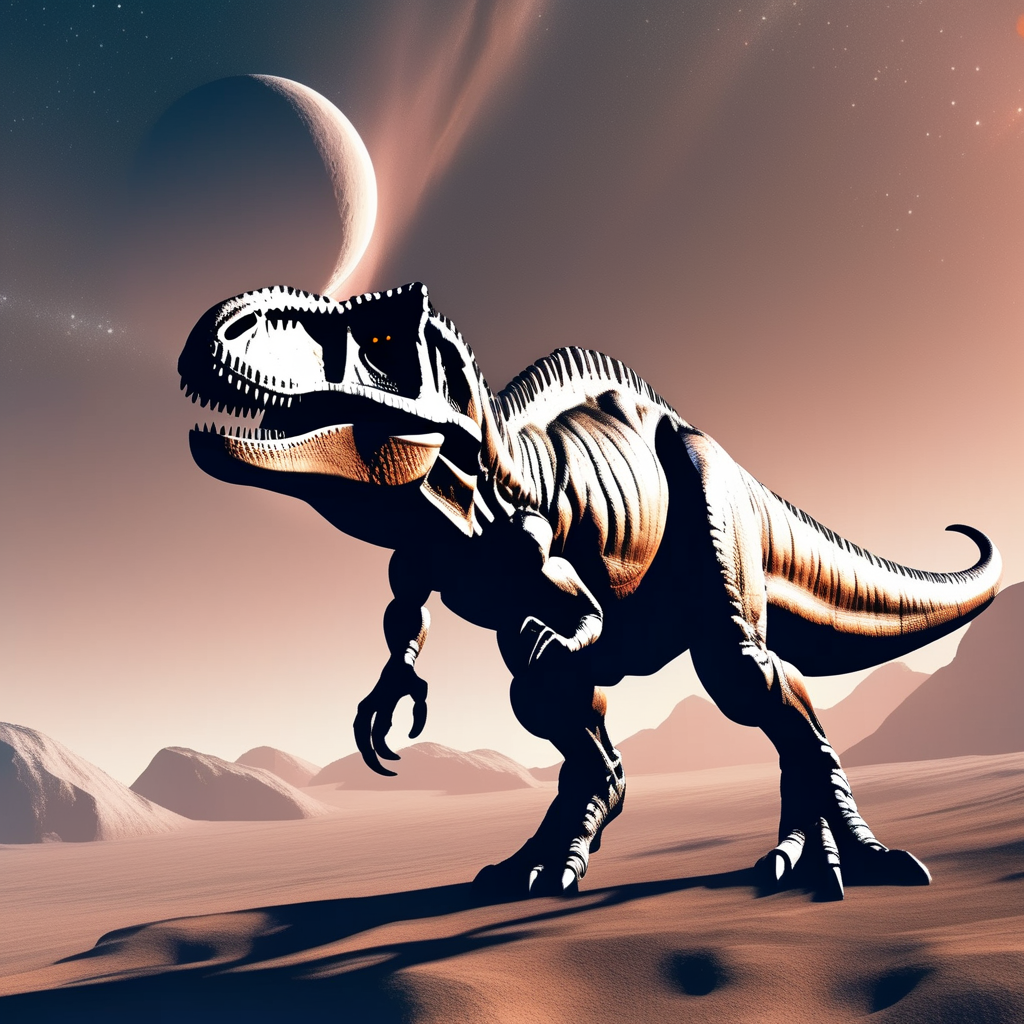

In [9]:
image = pipe("A picture of a Tyrannosaurus Rex in space", num_inference_steps=75).images[0]

image

In [8]:
!torch-model-archiver --model-name stable-diffusion \
    --version 1.0 \
    --handler stable_diffusion_handler.py \
    --extra-files tuned-weights/pytorch_lora_weights.safetensors \
    --requirements-file requirements.txt \
    --force #replace if already exists

WARNING - Overwriting /opt/app-root/src/SDXL-TRAIN/stable-diffusion.mar ...
